# Exploration and Evaluation

In [33]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import Tree
from Model import Agent
import matplotlib.pyplot as plt
import torch
import pickle

## Loading Files and Setting Values

In [18]:
# Load in Data
x_file = 'Synthetic_Data/batch_4/x_gen_syn_n2_p20_corr0.8_snr5_b0.6_seed2034_0.csv' 
y_file = 'Synthetic_Data/batch_4/y_gen_syn_n2_p20_corr0.8_snr5_b0.6_seed2034_0.csv'
x = np.loadtxt(x_file, delimiter=",")
y = np.loadtxt(y_file, delimiter=",")

# Fit a linear regression model to estimate coefficients (betas)
linear_model = LinearRegression()
linear_model.fit(x, y)

# Calculate the maximum absolute coefficient value
max_abs_beta = np.max(np.abs(linear_model.coef_))

# Specify l0 and l2 values
l0 =  max(abs(np.dot(x.T, y))) * .15
l2 = 0.0

# Calculate the optimal M value as 1.5 times the maximum absolute coefficient value
m = 1.5 * max_abs_beta

print(f"L0 Value: {l0}")
print(f"Optimal M: {m}")

L0 Value: 0.12605725376420232
Optimal M: 1.2411368973065564


## Branch and Bound Algorithm

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

### Rough Visualization of Tree Structure

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

def _hierarchy_pos(G, root, width=2., vert_gap = 0.1, vert_loc = 0, xcenter = 0.5, pos = None, parent = None, parsed = []):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    
    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)  
            
    if len(children) != 0:
        dx = width / len(children) 
        nextx = xcenter - width/2 - dx/2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(G, child, width = dx, vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, parent=root, parsed=parsed)
    
    return pos

def visualize_tree(root):
    if not root:
        return

    tree_graph = nx.DiGraph()

    def add_nodes_edges(node):
        if node.left:
            tree_graph.add_edge(node.node_key, node.left.node_key)
            add_nodes_edges(node.left)
        if node.right:
            tree_graph.add_edge(node.node_key, node.right.node_key)
            add_nodes_edges(node.right)

    add_nodes_edges(root)

    pos = hierarchy_pos(tree_graph, root.node_key)
    nx.draw(tree_graph, pos=pos, with_labels=True, node_size=100, node_color="skyblue", font_size=6, font_weight='bold')
    plt.title("Binary Tree Visualization")
    plt.show()

In [19]:
## Max Fraction Branch ##
p = Tree.Problem(x,y,l0,l2, m)
t = Tree.tree(p)
i, nnz, opt_gap = t.branch_and_bound('max') # also strong_branch or random

print(f'Number of iterations: {i}')
print(f'Number of Non-Zero: {nnz}')
print(f'Optimality Gap: {opt_gap}')

Number of iterations: 94
Number of Non-Zero: 1
Optimality Gap: 0.0


In [22]:
## Reinforcement Learning ##

# initialize agent
agent = Agent(34)

# Solve Using RL Agent
p = Tree.Problem(x,y,l0,l2, m)
t = Tree.tree(p)
iters, tot_reward, nnz, opt_gap = agent.RL_solve(t, training=True)

print(f'Iterations This Episode: {iters}')
print(f'Total Reward this Episode: {tot_reward}')
print(f'Number of Non-Zero: {nnz}')
print(f'Optimality Gap: {opt_gap}')
print(f'Number of Items in Memory: {len(agent.memory.memory)}')
print("-----------------------------------------")
print(f'Episodes Played: {agent.episodes_played}')
print(f'Epsilon: {round(agent.epsilon,4)}')

Iterations This Episode: 94
Total Reward this Episode: -49
Number of Non-Zero: 1
Optimality Gap: 0.0
Number of Items in Memory: 128
-----------------------------------------
Episodes Played: 1
Epsilon: 0.9511


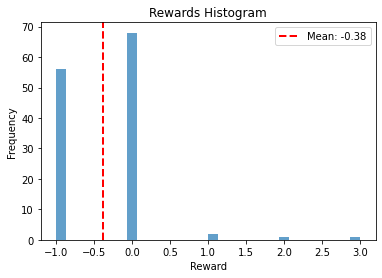

In [27]:
## REWARDS ## 

rewards = []

for transition in agent.memory.memory:        
        rewards.append(transition[2].item())

# Analyze the Reward Distribution
# Calculating the mean reward for each state pair
mean_rewards = np.mean(rewards)

# Plotting the histogram
plt.hist(rewards, bins=30, alpha=0.7)
plt.axvline(mean_rewards, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_rewards:.2f}")
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title("Rewards Histogram")
plt.legend()
plt.show()

## Evaluating Results

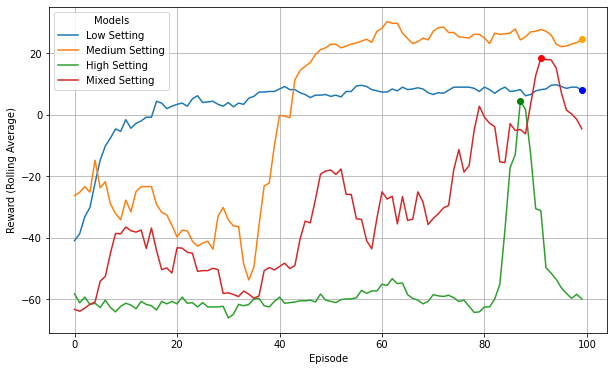

In [28]:
### TRAINING ###

import re
import matplotlib

# Read the Results CSV file
file_path = 'Results/results22.csv' 
p10 = pd.read_csv(file_path)

file_path = 'Results/results23.csv' 
p50 = pd.read_csv(file_path)

file_path = 'Results/results24.csv' 
p100 = pd.read_csv(file_path)

file_path = 'Results/results25.csv' 
Mixed = pd.read_csv(file_path)

w = 5
p10_r = p10['RL_rewards'].rolling(window=w, center=True, min_periods=1).mean()
p50_r  = p50['RL_rewards'].rolling(window=w, center=True, min_periods=1).mean()
p100_r = p100['RL_rewards'].rolling(window=w, center=True, min_periods=1).mean()
mixed_r = Mixed['RL_rewards'].rolling(window=9, center=True, min_periods=1).mean()


# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(p10_r, label='Low Setting')
plt.plot(p50_r, label='Medium Setting')
plt.plot(p100_r, label='High Setting')
plt.plot(mixed_r, label='Mixed Setting')
plt.xlabel('Episode')
plt.ylabel('Reward (Rolling Average)')

# Markers adjusted
plt.plot(91, 18.44, marker='o',linestyle='-',color='r')
plt.plot(99, 8, marker='o',linestyle='-',color='b')
plt.plot(87, 4.44, marker='o',linestyle='-',color='g')
plt.plot(99, 24.7, marker='o',linestyle='-',color='orange')
plt.legend()
plt.grid(True)
plt.legend(title='Models')
plt.show()

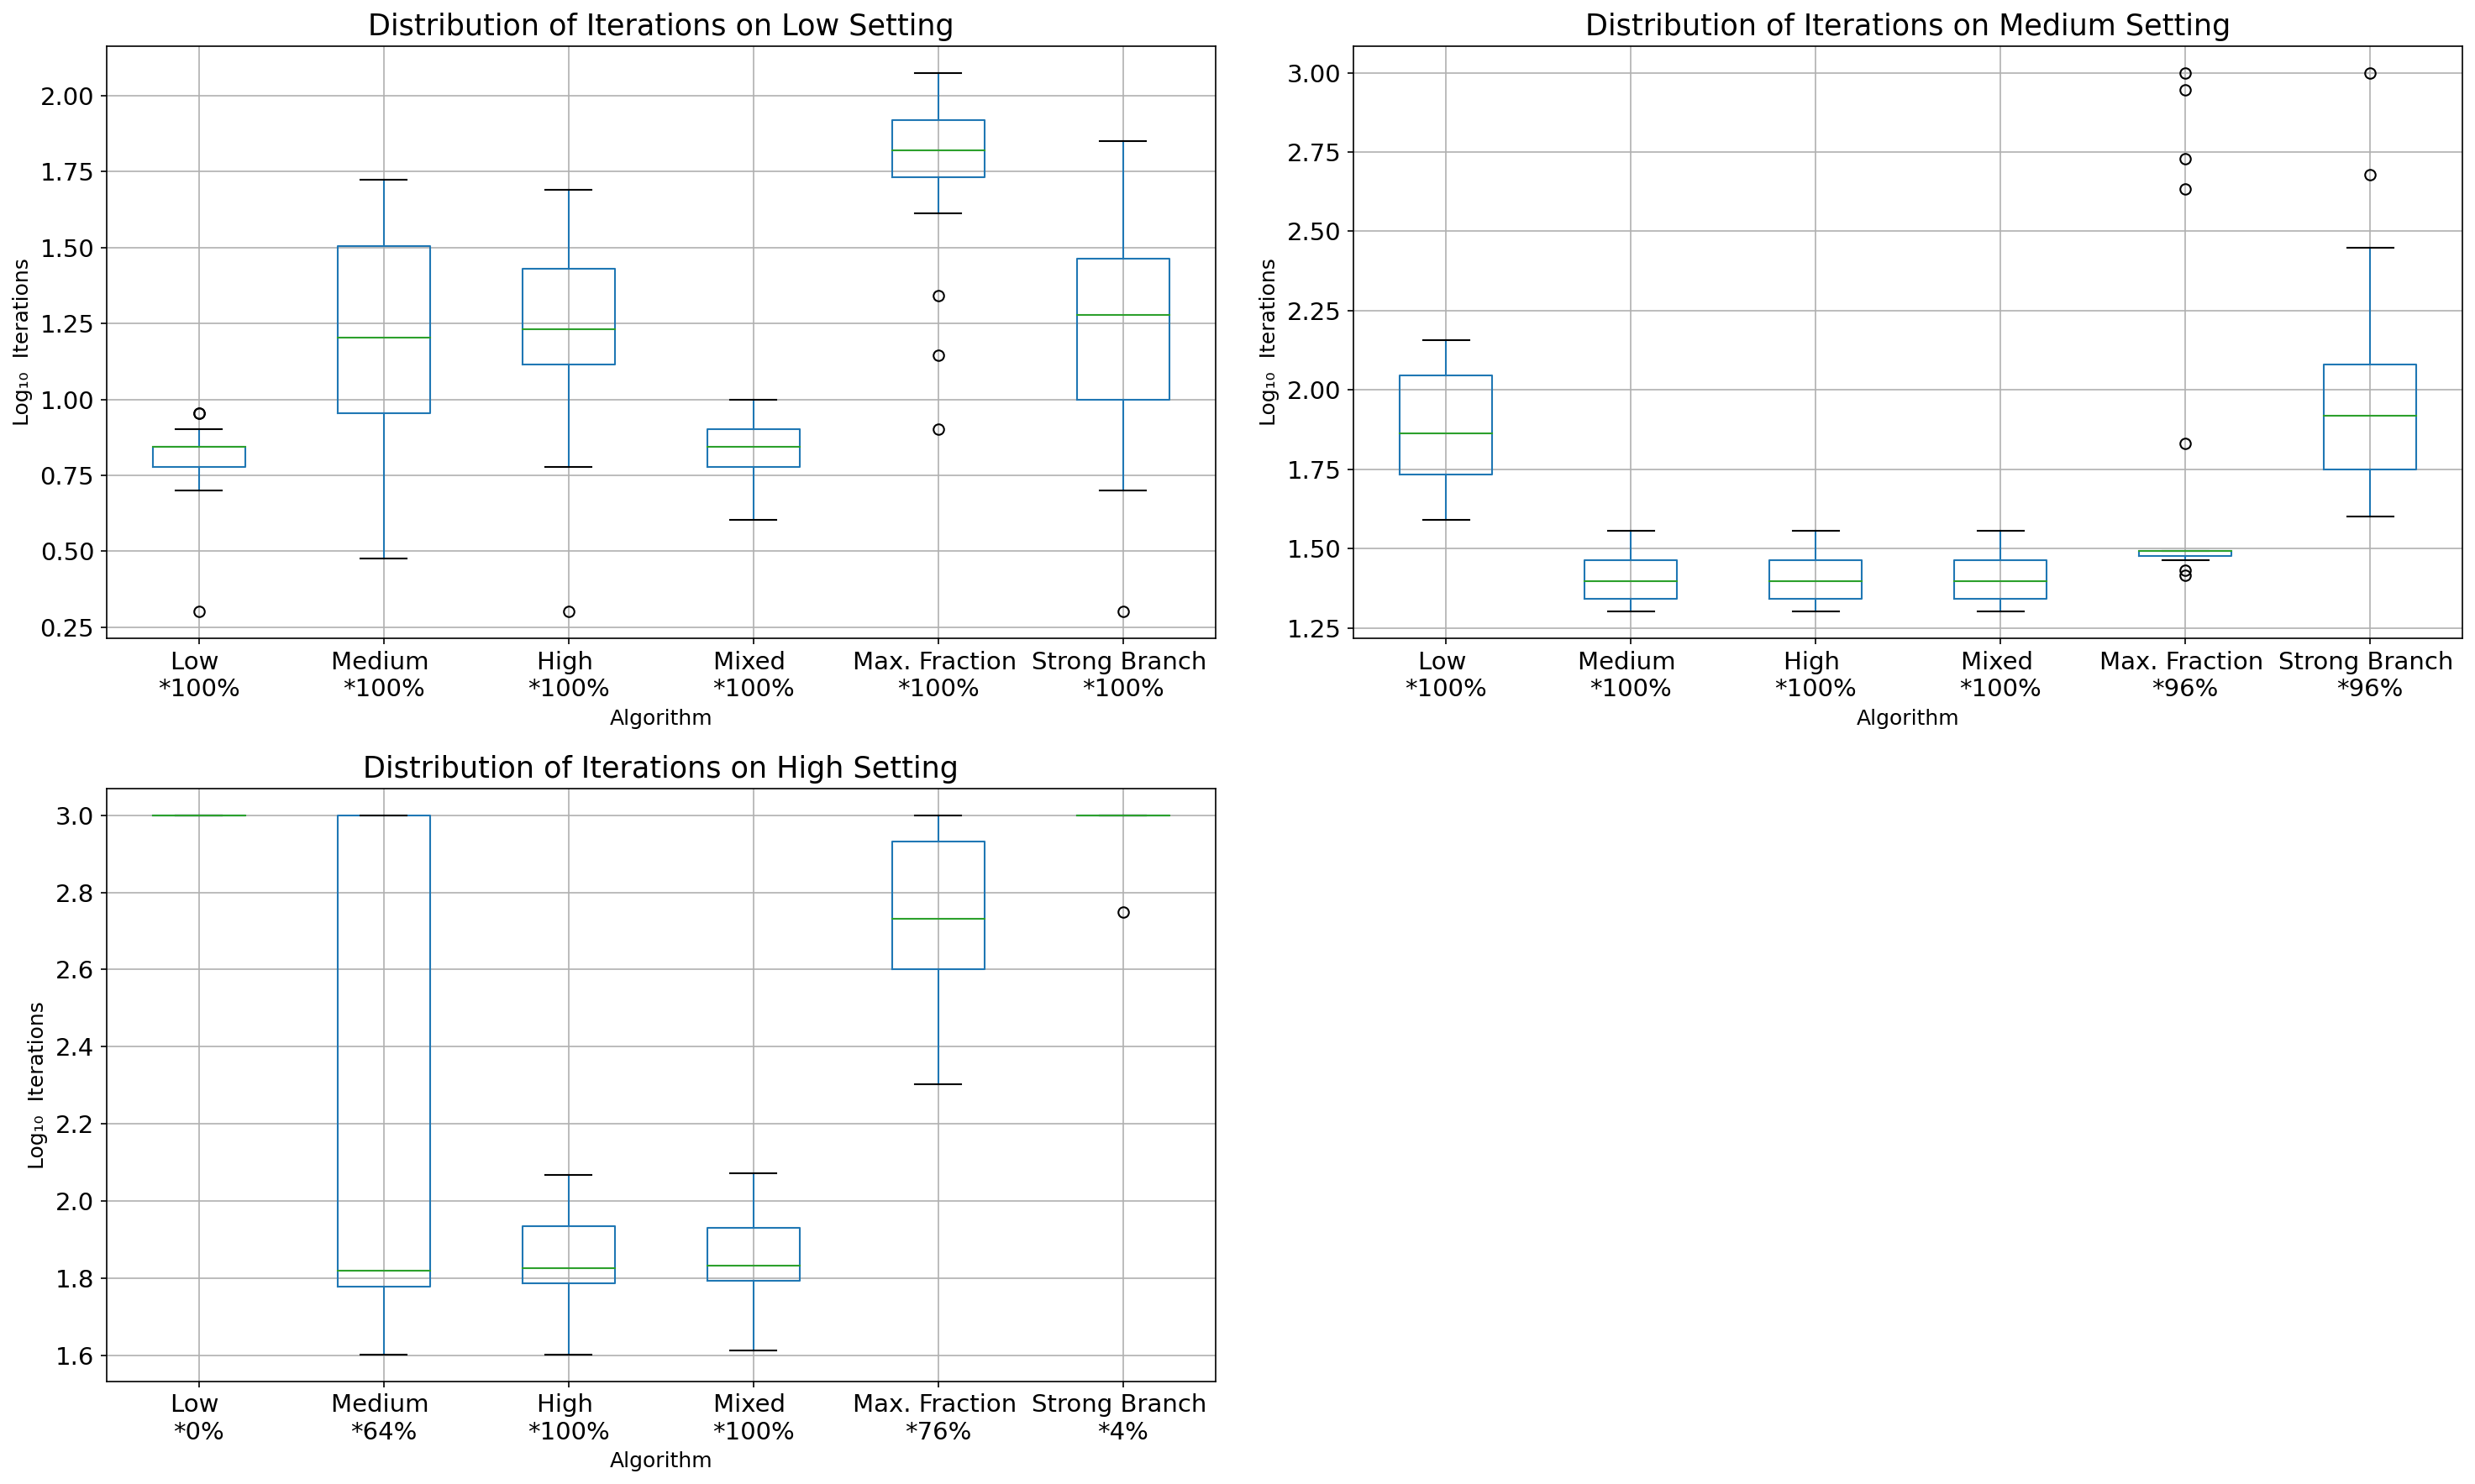

In [30]:
### VALIDATION ###
matplotlib.rcParams.update({'font.size': 14, 'axes.labelsize': 12})

# Load the datasets
df1 = pd.read_csv('Results/p10_comp.csv')
df2 = pd.read_csv('Results/p50_comp.csv')
df3 = pd.read_csv('Results/p100_comp.csv')

# Define the function to plot each DataFrame
def plot_df(ax, df, title):
    iter_cols = ['RL_iters_p10', 'RL_iters_p50', 'RL_iters_p100', 'RL_iters_mixed', 'MF_iters', 'SB_iters']
    percentages = [str(int(df[col][df[col] < 1000].shape[0] / df.shape[0] * 100)) + '%' for col in iter_cols]
    df[iter_cols] = np.log10(df[iter_cols])
    names = [f'Low \n*{percentages[0]}', f'Medium \n*{percentages[1]}', f'High \n*{percentages[2]}',
             f'Mixed \n*{percentages[3]}', f'Max. Fraction \n*{percentages[4]}', f'Strong Branch \n*{percentages[5]}']
    
    df[iter_cols].boxplot(showfliers=True, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Log₁₀  Iterations')
    ax.set_xlabel('Algorithm')
    ax.set_xticklabels(names, rotation=0)
    ax.grid(True)

# Create a figure and axes for the subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 12), dpi=150)

# Plot each DataFrame on its subplot
plot_df(axs[0, 0], df1, 'Distribution of Iterations on Low Setting')
plot_df(axs[0, 1], df2, 'Distribution of Iterations on Medium Setting')
plot_df(axs[1, 0], df3, 'Distribution of Iterations on High Setting')

# Leave the last subplot empty
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [32]:
### TESTING ###

df = pd.read_csv('Results/Final.csv')

# Extract the pXX number, multiply by 0.1, and add as a new column
df['True_nnz'] = df['data'].apply(lambda x: int(re.search("_p(\d+)_", x).group(1)) * 0.1)

# Filter the DataFrame
filtered_df = df[((df['RL_nnz'] == df['True_nnz']) & (df['RL_iters'] < 1000)) |
                 ((df['MF_nnz'] == df['True_nnz']) & (df['MF_iters'] < 1000)) |
                 ((df['SB_nnz'] == df['True_nnz']) & (df['SB_iters'] < 1000))].reset_index()

print('--------GAMES COMPLETED---------')
print('Proportion Completed')
print('--------------------------------')
print(f"% Episodes RL Completed: {len(df[df['RL_iters'] < 1000])/100}")
print(f"% Episodes MF Completed: {len(df[df['MF_iters'] < 1000])/100}")
print(f"% Episodes SB Completed: {len(df[df['SB_iters'] < 1000])/100}")
print('--------------------------------')
print('Iterations')
print('--------------------------------')
print(f"RL Iterations: {round(np.mean(df[df['RL_iters'] < 1000]['RL_iters']),1)} ({round(np.std(df[df['RL_iters'] < 1000]['RL_iters']), 2)})")
print(f"MF Iterations: {round(np.mean(df[df['MF_iters'] < 1000]['MF_iters']),1)} ({round(np.std(df[df['MF_iters'] < 1000]['MF_iters']), 2)})")
print(f"SB Iterations: {round(np.mean(df[df['SB_iters'] < 1000]['SB_iters']),1)} ({round(np.std(df[df['SB_iters'] < 1000]['SB_iters']), 2)})")
print('--------------------------------')
print('Accurately Completed')
print('--------------------------------')
# Percent Games Completed Accurately
print(f"% Episodes RL found True NNZ: {len(filtered_df['num_file'])/100}")
print(f"% Episodes MF found True NNZ: {len(filtered_df[filtered_df['MF_iters'] < 1000]['num_file'])/100}")
print(f"% Episodes SB found True NNZ: {len(filtered_df[filtered_df['SB_iters'] < 1000]['num_file'])/100}")

print('\n------GAMES INCOMPLETE---------')
print('Iterations')
print('--------------------------------')
print(f"RL Opt Gap: {round(np.mean(df[df['RL_iters'] == 1000]['RL_OG']),2)} ({round(np.std(df[df['RL_iters'] == 1000]['RL_OG']), 2)})")
print(f"MF Opt Gap: {round(np.mean(df[df['MF_iters'] == 1000]['MF_OG']),2)} ({round(np.std(df[df['MF_iters'] == 1000]['MF_OG']), 2)})")
print(f"SB Opt Gap: {round(np.mean(df[df['SB_iters'] == 1000]['SB_OG']),2)} ({round(np.std(df[df['SB_iters'] == 1000]['SB_OG']), 2)})")

--------GAMES COMPLETED---------
Proportion Completed
--------------------------------
% Episodes RL Completed: 0.5
% Episodes MF Completed: 0.19
% Episodes SB Completed: 0.21
--------------------------------
Iterations
--------------------------------
RL Iterations: 42.3 (43.8)
MF Iterations: 85.8 (121.73)
SB Iterations: 113.3 (177.47)
--------------------------------
Accurately Completed
--------------------------------
% Episodes RL found True NNZ: 0.26
% Episodes MF found True NNZ: 0.14
% Episodes SB found True NNZ: 0.15

------GAMES INCOMPLETE---------
Iterations
--------------------------------
RL Opt Gap: 0.35 (0.23)
MF Opt Gap: 0.41 (0.28)
SB Opt Gap: 0.34 (0.21)


## Feature Importance

1. Covariance Quantile 0%
2. Covariance Quantile 25%
3. Covariance Quantile 50%
4. Covariance Quantile 75%
5. Covariance Quantile 100%
6. X dot y Quantile 0%
7. X dot y Quantile 25%
8. X dot y Quantile 50%
9. X dot y Quantile 75%
10. X dot y Quantile 100%
11. Variable Count
12. x_i Covariance 0%
13. x_i Covariance 25%
14. x_i Covariance 50%
15. x_i Covariance 75%
16. x_i Covariance 100%
17. x_i dot y
18. Steps Taken
19. Active Nodes
20. Candidate Variables
21. Lower Bound
22. Best Integer
23. Initial Gap
24. Current Gap
25. zub Length
26. zlb Length
27. Primal Value
28. Node Level
29. Support Length
30. Has Lower Bound
31. Has Upper Bound
32. Primal Beta
33. Z Value
34. Upper Z Value

In [34]:
### LOAD MODEL AND STORE EPISODE IN MEMORY ###

with open('Models\memory.pkl', 'rb') as memory_file:
    loaded_memory = pickle.load(memory_file)

# Load Model
Check_agent = Agent(34)
Check_agent.policy_net.load_state_dict(torch.load(f"Models/mixed_model.pt"))
Check_agent.memory.memory = loaded_memory

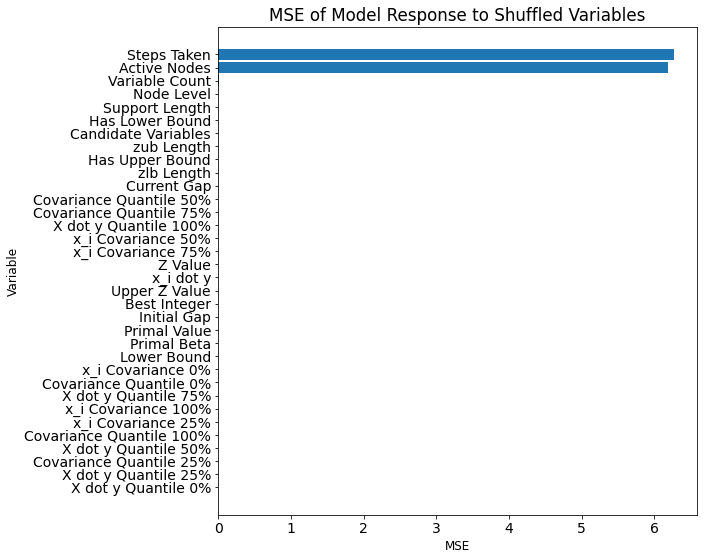

In [35]:
### VARIABLE IMPORTANCE ###
torch.manual_seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import torch  

# Labels for each of the 34 variables
variable_labels = [
    "Covariance Quantile 0%", "Covariance Quantile 25%", "Covariance Quantile 50%",
    "Covariance Quantile 75%", "Covariance Quantile 100%", "X dot y Quantile 0%",
    "X dot y Quantile 25%", "X dot y Quantile 50%", "X dot y Quantile 75%",
    "X dot y Quantile 100%", "Variable Count", "x_i Covariance 0%",
    "x_i Covariance 25%", "x_i Covariance 50%", "x_i Covariance 75%",
    "x_i Covariance 100%", "x_i dot y", "Steps Taken", "Active Nodes",
    "Candidate Variables", "Lower Bound", "Best Integer", "Initial Gap",
    "Current Gap", "zub Length", "zlb Length", "Primal Value", "Node Level",
    "Support Length", "Has Lower Bound", "Has Upper Bound", "Primal Beta",
    "Z Value", "Upper Z Value"
]

# Each Item in memory is (prev_state, state, reward)
memory = Check_agent.memory.memory

# Extracting all states from memory
all_states = torch.cat([transition.prev_state for transition in memory])
all_true_responses = Check_agent.policy_net(all_states).detach().numpy()

variable_mse = {variable: [] for variable in variable_labels}

num_shuffles = 30

for _ in range(num_shuffles):
    for i, variable in enumerate(variable_labels):
        shuffled_states = all_states.clone().numpy() # Copy so we can alter

        # Shuffle the current variable across all states
        np.random.shuffle(shuffled_states[:, i])

        # Convert back to tensor and get model responses for the shuffled states
        shuffled_states_tensor = torch.tensor(shuffled_states, dtype=torch.float)
        shuffled_responses = Check_agent.policy_net(shuffled_states_tensor).detach().numpy()

        # Calculate MSE between true responses and responses to shuffled states
        mse = mean_squared_error(all_true_responses, shuffled_responses)
        variable_mse[variable].append(mse)

# Average the MSEs for each variable
average_variable_mse = {variable: np.mean(mses) for variable, mses in variable_mse.items()}

# Plotting
sorted_variable_mse = sorted(average_variable_mse.items(), key=lambda x: x[1])
variables, mses = zip(*sorted_variable_mse)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(variables, mses) 
ax.set_ylabel('Variable')
ax.set_xlabel('MSE')
ax.set_title('MSE of Model Response to Shuffled Variables')

plt.tight_layout()
plt.show()

## Generating Random 'Realistic' Data

In [45]:
from .Synthetic_Data import gen_syn_data

n_datasets = 25

# Parameters for variety (extended or repeated to ensure variety across datasets)
n_samples_options = np.random.randint(500, 1500, 25)
p_features_options = np.round(np.random.randint(10, 150, 25),-1)
rhos_options = np.random.randint(5,10,25)/10
snrs_options = np.random.randint(2, 6, 25)
binary_options = np.random.randint(0,10,25)/10
seeds = range(2022, 2047)  # Unique seeds for each dataset

for i in range(n_datasets):
    # Selecting parameters for the current dataset
    n = n_samples_options[i]
    p = p_features_options[i]
    rho = rhos_options[i]
    snr = snrs_options[i]
    seed = seeds[i]
    binary_prop = binary_options[i]
    
    # Generate the dataset with the chosen parameters
    gen_syn_data.make_syn_data(n_mat=1, n=n, p=p, rho=rho, snr=snr, batch_n=i+1, seed=seed, binary_prop=binary_prop)